In [1]:
import torch
import torch.nn as nn
from scipy.io import loadmat
import numpy as np
import random as rand
import mlmodel
import math
import pickle as pkl
import chart_studio.plotly as py
from importlib import reload
import plotly.graph_objects as go
from functools import reduce

import pose_2D as pose2d
import pose_3D as pose3d
import pose_2D_torch as pose2dtorch
import pose_3D_torch as pose3dtorch
import visual as vs

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [2]:
import time, sys
from IPython.display import clear_output

def update_progress(progress,  message):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)
    for m in message:
        print(m)

In [3]:
torch.cuda.is_available()

True

In [5]:
!nvidia-smi

Mon Dec  2 16:59:25 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0 Off |                  N/A |
| 31%   55C    P8    10W / 250W |     27MiB / 11016MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:03:00.0 Off |                  N/A |
| 55%   73C    P2   222W / 257W |   7107MiB / 11019MiB |     85%      Default |
+-------------------------------+----------------------+----------------------+
        

In [6]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
torch.cuda.current_device()

1

In [7]:
data_set_3d, data_set_2d, data_set_angles, data_set_props,data_depths, base_3dpose_data = \
                                                                        pkl.load(open("data/DATASETv_5a.pkl", "rb"))

In [22]:
import matplotlib.pyplot as plt

In [41]:
def project_to_pixels(xyz, kk):
    """Project a single point in space into the image"""
    xx, yy, zz = np.dot(kk, xyz)
    uu = int(xx / zz)
    vv = int(yy / zz)

    return uu, vv
def project_pose_2cam(pose, kk, z_shift, joints2keep):
    
    pose_moved = pose.copy()
    pose_moved[2] += z_shift
    projected_pose = []
    
    for point in pose_moved.transpose():
        projected_pose.append(list(project_to_pixels(point, kk)))
    
    projected_pose = np.array(projected_pose).transpose().astype(float)
    joints_indices = [pose2d.joint_dict[x] for x in joints2keep]
    shift = (projected_pose[:,pose2d.joint_dict['right hip']] + 
             projected_pose[:,pose2d.joint_dict['left hip']]).reshape((2,1))/2
    projected_pose[:,joints_indices] = pose2d.normalize(projected_pose[:,joints_indices], shift)
    projected_pose = pose2d.filter_joints(projected_pose, joints2keep, -10).transpose().flatten()

    return projected_pose

In [42]:
LOGI_KK = [[0.7477614068838029, -0.0008111695246478873,  0.5134789751408451],
           [0.0,                      1.33178042553125, 0.45684016428124996],
           [0.                ,                     0.,                  1.]]

width, height = 192, 108

kk = [[x*width  for x in LOGI_KK[0]],
      [x*height for x in LOGI_KK[1]],
      LOGI_KK[2]]

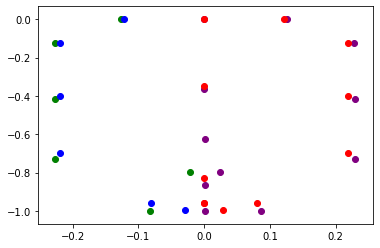

In [53]:
depth = 0.2
pro_pose = project_pose_2cam(base_3dpose_data[0], kk, depth, joints2keep).reshape((21,2)).transpose()
for joint in pose3d.joint_names:
    if joint in joints2keep:
        if 'right' in joint:
            plt.scatter(pro_pose[0][pose3d.joint_dict[joint]],pro_pose[1][pose3d.joint_dict[joint]], c='green')
        else:
            plt.scatter(pro_pose[0][pose3d.joint_dict[joint]],pro_pose[1][pose3d.joint_dict[joint]], c='purple')

joints2keep = ['left hip', 'right hip', 'nose', 'right shoulder','left shoulder', 'right eye','left eye',
               'right ear','left ear','center shoulder','center hip','center back','head', 'right elbow',
              'right wrist', 'left elbow', 'left wrist']
for joint in pose3d.joint_names:
    if joint in joints2keep:
        if 'right' in joint:
            plt.scatter(base_3dpose_data[0][0][pose3d.joint_dict[joint]],base_3dpose_data[0][1][pose3d.joint_dict[joint]], c='blue')
        else:
            plt.scatter(base_3dpose_data[0][0][pose3d.joint_dict[joint]],base_3dpose_data[0][1][pose3d.joint_dict[joint]], c='red')

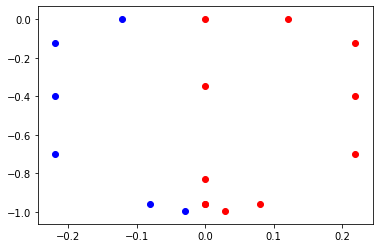

In [ ]:
base_3dpose_data[0]

In [35]:
data_set_3d[0]

array([-0.23106536,  0.0016237 ,  0.72954707, -0.19661199,  0.03749859,
        0.4551198 , -0.24849364, -0.20829254,  0.29132627, -0.16778946,
        0.03076067,  0.17952503, -0.21792482, -0.38868155,  0.55399543,
       -0.11876305, -0.17284492,  0.7370659 , -0.2395581 , -0.23139061,
        0.97818844, -0.10643628,  0.05079222, -0.02942738,  0.0774671 ,
        0.33029173, -0.21216845,  0.25247397,  0.59627018, -0.38606925,
        0.10643628, -0.05079222,  0.02942738,  0.29033965,  0.2287073 ,
       -0.1533137 ,  0.46534652,  0.49468575, -0.32721449, -0.27325551,
       -0.04512874,  0.77036241, -0.21613052, -0.04958073,  0.78233673,
       -0.3241023 , -0.10833963,  0.73924665, -0.16708735, -0.12057647,
        0.77215951, -0.22186708, -0.14553744,  0.63095172,  0.        ,
        0.        ,  0.        , -0.16830834, -0.25579791,  0.1672446 ,
       -0.24559482, -0.11445805,  0.75570308])